In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler   #標準化
from sklearn.ensemble import RandomForestClassifier   #ランダムフォレスト
from sklearn.linear_model import SGDClassifier   #クラス分類
from sklearn.metrics import log_loss, accuracy_score   #対数尤度, 正答率
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix   #適合率, 再現率, F1値, 混合行列
from sklearn.model_selection import KFold # 交差検証法に関する関数

In [2]:
df = pd.read_csv("./data/ks-projects-201801.csv")
# stateの値がsuccessfulなら1(True)，そうでなければ0(False)に変更
df['state'] = df['state'] == 'successful' 

# 上から7番目までのデータを表示
display(df.head(7))

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,False,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,False,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,False,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,False,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,False,14,US,1283.0,1283.0,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,True,224,US,52375.0,52375.0,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.0,True,16,US,1205.0,1205.0,1000.00


In [3]:
#統計値
display(df.describe())
#欠損値がある行数
display(df.isnull().sum())
#各列のデータタイプ
display(df.dtypes)

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

ID                    int64
name                 object
category             object
main_category        object
currency             object
deadline             object
goal                float64
launched             object
pledged             float64
state                  bool
backers               int64
country              object
usd pledged         float64
usd_pledged_real    float64
usd_goal_real       float64
dtype: object

In [53]:
#文字列を数値に置き換える
df2=pd.get_dummies(df, columns=["category", "main_category", "currency", "country"])

In [5]:
#クラウドファンディングの期間
import datetime
from datetime import datetime, date, timezone, timedelta

df2["deadline"]=pd.to_datetime(df2["deadline"], errors="coerce")
df2["launched"]=pd.to_datetime(df2["launched"], errors="coerce")

d1 = (df2["deadline"])
d2 = (df2["launched"])
dt=abs(d1-d2)

#期間をsecondで表す
df2["term"]=dt.dt.seconds+dt.dt.days*86400


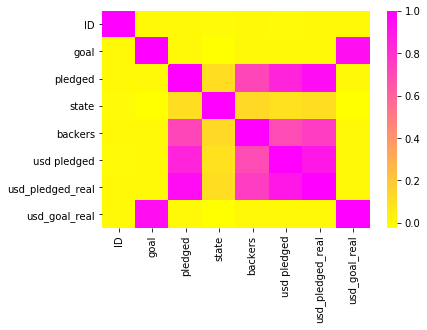

In [6]:
sns.heatmap(df.corr(), cmap="spring_r")

相関係数: 0.943


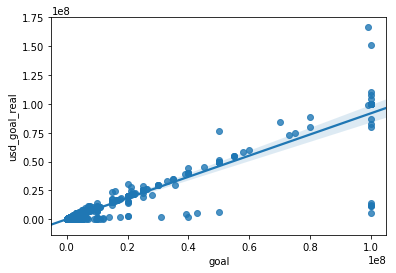

In [7]:
#"goal"と"usd_goal_real"の相関を確認
sns.regplot(df2.goal, df2.usd_goal_real)
print('相関係数: {:.3f}'.format(np.corrcoef(df2.goal, df2.usd_goal_real)[0,1]))

In [8]:
#  無相関化を行うための一連の処理
x = df2.loc[:, ["goal", "usd_goal_real"]]
cov = np.cov(x, rowvar=0) # 分散・共分散を求める
_, S = np.linalg.eig(cov)           # 分散共分散行列の固有ベクトルを用いて
x_decorr = np.dot(S.T, x.T).T #データを無相関化

相関係数: 0.000


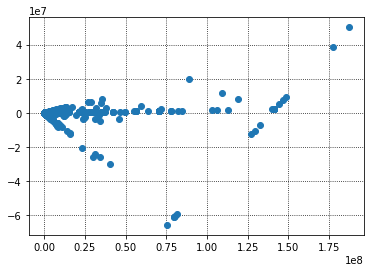

In [9]:
#無相関化されているかを確認
print('相関係数: {:.3f}'.format(np.corrcoef(x_decorr[:, 0], x_decorr[:, 1])[0,1]))
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(x_decorr[:, 0], x_decorr[:, 1], 'o')
plt.show()

相関係数: 0.000


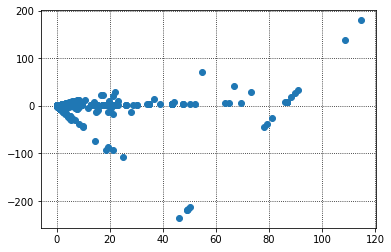

In [10]:
#  白色化を行うための一連の処理
stdsc = StandardScaler()
stdsc.fit(x_decorr)
x_whitening  = stdsc.transform(x_decorr) # 無相関化したデータに対して、さらに標準化

print('相関係数: {:.3f}'.format(np.corrcoef(x_whitening[:, 0], x_whitening[:, 1])[0,1]))
plt.grid(which='major',color='black',linestyle=':')
plt.grid(which='minor',color='black',linestyle=':')
plt.plot(x_whitening[:, 0], x_whitening[:, 1], 'o')
plt.show()

In [11]:
#ランダムフォレストによる特徴量選択
from sklearn.ensemble import RandomForestClassifier

y = df2["state"].values

#選択する説明変数は以下のものを外す
#"ID", "name" → "state" の分類に関係しないと考えられる
# "pledged", "state", "usd_pledged_real", "usd pledged" → 未来で分かる結果なので組み込めない
#"state" → 目的変数
#"launched", "deadline" → "term" で置き換えている
df3 = df2.drop(["ID", "name", "pledged", "state", "usd_pledged_real", "usd pledged", "launched", "deadline"], axis =1)
X = df3.values

#特徴量
X_train = X
#target
y_train = y


#実務ではestimatorを100とか500にする
clf = RandomForestClassifier(n_estimators=25, max_depth=3, criterion="gini",
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(X_train, y_train)
print("score=", clf.score(X_train, y_train))

# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
fti = clf.feature_importances_

score= 0.6484797747853621


In [12]:
for i, feat in enumerate(df3.columns):
    print('\t{0:20s} : {1:>.6f}'.format(feat, fti[i]))

	goal                 : 0.041960
	backers              : 0.161081
	usd_goal_real        : 0.187274
	category_3D Printing : 0.000000
	category_Academic    : 0.000000
	category_Accessories : 0.000773
	category_Action      : 0.000000
	category_Animals     : 0.000000
	category_Animation   : 0.000000
	category_Anthologies : 0.000000
	category_Apparel     : 0.011204
	category_Apps        : 0.071838
	category_Architecture : 0.000000
	category_Art         : 0.000000
	category_Art Books   : 0.000000
	category_Audio       : 0.000000
	category_Bacon       : 0.000000
	category_Blues       : 0.000000
	category_Calendars   : 0.000000
	category_Camera Equipment : 0.000028
	category_Candles     : 0.000000
	category_Ceramics    : 0.000000
	category_Children's Books : 0.000000
	category_Childrenswear : 0.000000
	category_Chiptune    : 0.000000
	category_Civic Design : 0.000000
	category_Classical Music : 0.017012
	category_Comedy      : 0.000000
	category_Comic Books : 0.000000
	category_Comics      : 0

In [13]:
indices = np.argsort(clf.feature_importances_)[::-1]
print(indices)

[  2   1  11 213 144 207 175 132   0 214 167 176  39 139  26  33 134 163
  10  75 151 172 128  57  91 164 154  37 181 110 174   5 190  35  29 197
  38 212  47 138 178 189 206 203 162 166 188 193 182 209 194 127 192  19
 210 200 195 198 187 201 196 179 211 137  58  80  51  56  54  53  52  55
  73  59  65  74  71  49  70  69  68  67  66  76  60  64  77  78  63  62
  79  61  72  50 204  48  46  21  20  18  17  16  15  14  13  12   9   8
   7   6   4   3  22  23  24  36  45  44  43  42  41  40  34  25  32  82
  31  30  28  27  81 102  83 158 156 155 153 152 150 149 148 147 146 145
 143 142 141 140 136 135 133 157 159 131 160 202 199 191 186 185 184 183
 180 177 205 173 171 170 169 168 165 161 208 130  84 105 103 101 100  99
  98  97  96  95  94  93  92  90  89  88  87  86  85 104 106 129 108 126
 125 124 123 122 121 120 119 118 117 116 115 114 113 112 111 109 107]


In [52]:
# 線形回帰のときと同様に説明変数を9つ("backers", "usd_goal_real", "category_Apps", "country_US", "category_Theater", "country_N,0", "main_category_Technology", "category_Shorts", "goal")に絞って，ロジスティック回帰
y = df2["state"].values
x = df2[["backers", "usd_goal_real", "category_Apps", "country_US", "category_Theater", 'country_N,0"', "main_category_Technology", "category_Shorts", "goal"]].values

# 各特徴量を平均0，分散1となるような前処理（標準化）を施す
std_scaler = StandardScaler() 

# fit_transform関数で標準化した特徴量X_scaledを得る
# 以降はX_scaledをモデルの学習等に使う
X_scaled = std_scaler.fit_transform(x)


#交差検証
n_split = 8 # グループ数を設定（今回は8分割）

cross_valid_LLV = 0
cross_valid_accuracy = 0
cross_valid_precision = 0
cross_valid_recall = 0
cross_valid_f1_score = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X_scaled, y):
    X_train, y_train = X_scaled[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X_scaled[test_idx], y[test_idx]     #テスト用データ
    
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
    clf.fit(X_train, y_train)
    
    y_pred2 = clf.predict(X_test)
    
    # 対数尤度を表示
    # log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
    LLV = - log_loss(y_test, y_pred2)
    
    # テストデータに対するaccuracyを計算
    accuracy =  accuracy_score(y_test, y_pred2)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred2)
    
    print("Fold %s"%split_num)
    print("accuracy = %s"%round(accuracy*100, 3))
    print("precision = {:.3f}%".format(100 * precision[1]))
    print("recall = {:.3f}%".format(100 * recall[1]))
    print("f1_score = {:.3f}%".format(100 * f1_score[1]))
    print()
    
    cross_valid_LLV += LLV #後で平均を取るために対数尤度を加算
    cross_valid_accuracy += accuracy #後で平均を取るためにaccuracyを加算
    cross_valid_precision += precision #後で平均を取るためにprecisionを加算
    cross_valid_recall += recall #後で平均を取るためにrecallを加算
    cross_valid_f1_score += f1_score #後で平均を取るためにf1_scoreを加算
    split_num += 1

# 対数尤度, accuracy, precision, recall, f1_scoreの平均値を示す
final_LLV = cross_valid_LLV / n_split
final_accuracy = cross_valid_accuracy / n_split
final_precision = cross_valid_precision / n_split
final_recall = cross_valid_recall / n_split
final_f1_score = cross_valid_f1_score / n_split
print("Cross Validation LLV = %s"%round(final_LLV))
print("Cross Validation accuracy = %s"%round(final_accuracy*100, 3))
print("Cross Validation precision = {:.3f}%".format(100 * final_precision[1]))
print("Cross Validation recall = {:.3f}%".format(100 * final_recall[1]))
print("Cross Validation f1_score = {:.3f}%".format(100 * final_f1_score[1]))
print(" ")
# 予測値と正解のクロス集計 (Fold8, test)
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_pred2), 
                        index=['正解 = successful', '正解 = failed'], 
                        columns=['予測 = successful', '予測 = failed'])
print("Confusion matrix (Fold 8)")
conf_mat

Fold 1
accuracy = 85.76
precision = 90.407%
recall = 66.917%
f1_score = 76.908%

Fold 2
accuracy = 87.353
precision = 90.425%
recall = 71.635%
f1_score = 79.941%

Fold 3
accuracy = 87.079
precision = 91.184%
recall = 70.479%
f1_score = 79.505%

Fold 4
accuracy = 85.45
precision = 88.165%
recall = 68.101%
f1_score = 76.845%

Fold 5
accuracy = 85.788
precision = 89.673%
recall = 67.469%
f1_score = 77.002%

Fold 6
accuracy = 86.028
precision = 90.732%
recall = 67.307%
f1_score = 77.284%

Fold 7
accuracy = 86.174
precision = 91.804%
recall = 67.075%
f1_score = 77.515%

Fold 8
accuracy = 86.476
precision = 89.938%
recall = 69.432%
f1_score = 78.365%

Cross Validation LLV = -5.0
Cross Validation accuracy = 86.264
Cross Validation precision = 90.291%
Cross Validation recall = 68.552%
Cross Validation f1_score = 77.921%
 
Confusion matrix (Fold 8)


,予測 = successful,予測 = failed
正解 = successful,29338,1297
正解 = failed,5104,11593
